# Ultra-short echo time (UTE) sequence for X-Nuclei imaging

This sequence is a modification from yesterdays radial sequence with a non-selective 3D center out gradient using an Archimedal spiral trajectory ([Wong S., et al.](https://doi.org/10.1002/mrm.1910320614)). You can find exercises at the bottom of this notebook!

**Initialization**

In [ ]:
import importlib
if importlib.util.find_spec('pypulseq') is None:
    !pip install -q mrzerocore git+https://github.com/imr-framework/pypulseq.git
!pip install -q git+https://github.com/imr-framework/pypulseq.git pymapvbvd

import math
import numpy as np

import matplotlib.pyplot as plt
import mapvbvd

import pypulseq as pp

!wget -nc https://raw.githubusercontent.com/pulseq/MR-Physics-with-Pulseq/main/utils/utils.py
from utils import animate, simulate_2d, recon_nufft_2d, read_raw_data, reconstruct
from copy import copy

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.1/349.1 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.0/234.0 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


/usr/local/lib/python3.10/dist-packages/sigpy/config.py:15: UserWarning: Importing cupy failed. For more details, see the error stack below:

Failed to import CuPy.

If you installed CuPy via wheels (cupy-cudaXXX or cupy-rocm-X-X), make sure that the package matches with the version of CUDA or ROCm installed.

On Linux, you may need to set LD_LIBRARY_PATH environment variable depending on how you installed CUDA/ROCm.
On Windows, try setting CUDA_PATH environment variable.

Check the Installation Guide for details:
  https://docs.cupy.dev/en/latest/install.html

Original error:
  ImportError: libcuda.so.1: cannot open shared object file: No such file or directory

  warnings.warn(


--2024-02-07 18:15:53--  https://raw.githubusercontent.com/pulseq/MR-Physics-with-Pulseq/main/utils/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36249 (35K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]  35.40K  --.-KB/s    in 0.004s  

2024-02-07 18:15:53 (8.26 MB/s) - ‘utils.py’ saved [36249/36249]



# **Create, simulate, and reconstruct sequence**

**Radial GRE Sequence definition**

Timing check passed successfully


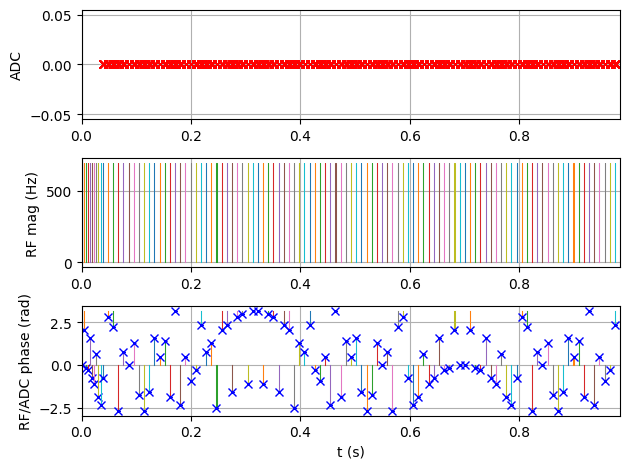

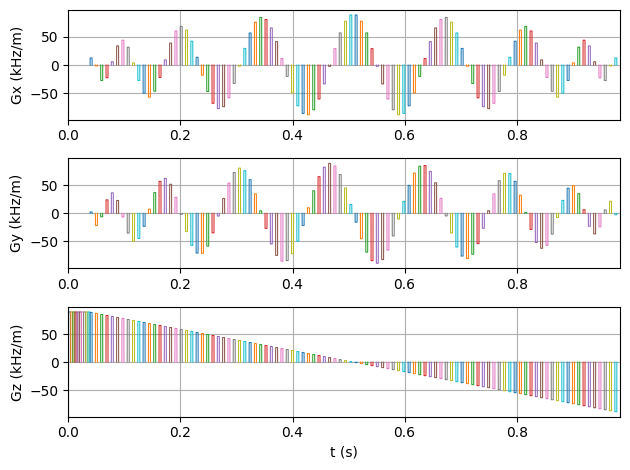

Number of blocks: 320
Number of events:
RF:    110
Gx:    100
Gy:    100
Gz:    110
ADC:    100
Delay:      0
Sequence duration: 0.984500 s
TE: 0.000112 s
TR: 0.009460 s
Flip angle: 15.00 deg
Unique k-space positions (aka cols, rows, etc.): 1700 3394 3384 
Dimensions: 3
Spatial resolution: 3.93 mm
Spatial resolution: 3.89 mm
Spatial resolution: 3.91 mm
Repetitions/slices/contrasts: 1.0; range: [(1.0, 1.0)]
Non-cartesian/irregular encoding trajectory detected (eg: EPI, spiral, radial, etc.)
Event timing check passed successfully
Max gradient: 88192 89205 89600 Hz/m == 2.07 2.10 2.10 mT/m
Max slew rate: 801743552 810953425 814545455 Hz/m/s == 18.83 19.05 19.13 T/m/s
Max absolute gradient: 89600 Hz/m == 2.10 mT/m
Max absolute slew rate: 8.14545e+08 Hz/m/s == 19.13 T/m/s


In [ ]:
plot = True
write_seq = False
seq_filename = "ute_3d.seq"

# ======
# SETUP
# ======
fov = 250e-3
Nx = 64  # Define FOV and resolution
alpha = 15  # Flip angle (only correct if reference voltag is calibrated)
# this sequence minimizes TE
TR = 9.5e-3  # Repetition time
BW = 350  # Hz/px
spoil_duration = 2e-3 # extend the readout gradientif desired. Not needed when T2* is short
Nr = 100 # Number of radial spokes
N_dummy = 10  # Number of dummy scans

ro_os = 2 # Readout oversampling
rf_spoiling_inc = 117  # RF spoiling increment

# Set system limits
system = pp.Opts(
    max_grad         = 28,
    grad_unit        = "mT/m",
    max_slew         = 150,
    slew_unit        = "T/m/s",
    rf_ringdown_time = 20e-6,
    rf_dead_time     = 100e-6,
    adc_dead_time    = 20e-6,
    gamma            = 5.772e6
)

seq = pp.Sequence(system)  # Create a new sequence object

# ======
# CREATE EVENTS
# ======
# Create alpha-degree non-selective rectangular pulse
rf = pp.make_block_pulse(
    duration   = 60e-6,
    flip_angle = alpha * np.pi / 180,
    system     = system,
)

# After excitation, we must wait for the Tx coil to ring down, otherwise the ADC ist overloaded.
# Similarly, switching between Tx and Rx is not instantaneous and we have to wait for adc_dead_time.
# Thus, the miminum time between rf and adc is the sum of both:
rf_adc_min_gap = system.rf_ringdown_time + system.adc_dead_time

# Define other gradients and ADC events
deltak = 1 / fov

### prepare parameters for the readout gradient
sr = 0.95*system.max_slew
amplitude = BW*Nx / fov
# calculate the timings
t0 = amplitude / sr
T  = Nx/2*deltak/amplitude + amplitude/2/sr
t0 = math.ceil(t0 / system.grad_raster_time) * system.grad_raster_time

### proceed with parameters for the adc
dwell_time = 1 / BW / Nx
# round DOWN to adc raster time to ensure Nyquist
dwell_time = math.ceil(dwell_time / system.adc_raster_time) * system.adc_raster_time
num_samples = math.ceil(T / dwell_time)
# make sure the number of samples is even
if (num_samples % 2) == 1:
    num_samples = num_samples+1

# create the adc object
adc = pp.make_adc(
    num_samples = num_samples,
    duration    = num_samples*dwell_time,
    delay       = rf_adc_min_gap, # here we add the delay between rf and adc
    system      = system
)

# finally, we can calculate the end point of the gradient and make sure that gradient is constant until the last ADC point is measured.
T = math.ceil(num_samples*dwell_time / system.grad_raster_time) * system.grad_raster_time
# and prepare the arrays that define the gradient (we choose the ramp down time to be equal to the ramp up time)
times      = np.array([0, t0, T, T+spoil_duration, T+spoil_duration+t0])
amplitudes = np.array([0, amplitude, amplitude, amplitude, 0])

# create the gradient object. The choice of channel is arbitrary here and will be overwritten later
# note that the gradient must be delayed too, to ensure that ADC and gradient start simultaneously
g = pp.make_extended_trapezoid(
    channel    = "x",
    amplitudes = amplitudes,
    times      = rf_adc_min_gap + times,
    system     = system
)


delay_TR = (
    np.ceil(
        (
            TR
            - pp.calc_duration(rf)
            - pp.calc_duration(g)
        )
        / seq.grad_raster_time
    )
    * seq.grad_raster_time
)
assert delay_TR >= 0

rf_phase = 0
rf_inc = 0

# ======
# CONSTRUCT SEQUENCE
# ======

# create components of the gradient along each gradient axis
gx = copy(g)
gy = copy(g)
gz = copy(g)
gx.channel = 'x'
gy.channel = 'y'
gz.channel = 'z'


for i in range(-N_dummy, Nr):
    # Set RF/ADC phase for RF spoiling, and increment RF phase
    rf.phase_offset = rf_phase / 180 * np.pi
    adc.phase_offset = rf_phase / 180 * np.pi

    rf_inc += rf_spoiling_inc
    rf_phase = (rf_inc + rf_phase) % 360

    # non-selective excitation pulse
    seq.add_block(rf)

    # Readout gradient, rotated by `phi`
    if i >= 0:

        # trajectory from: 10.1002/mrm.1910320614
        z_scale = -(2*(i+1)-Nr-1) / Nr
        x_scale = np.cos(np.sqrt(Nr*np.pi)*np.arcsin(z_scale)) * np.sqrt(1-z_scale**2)
        y_scale = np.sin(np.sqrt(Nr*np.pi)*np.arcsin(z_scale)) * np.sqrt(1-z_scale**2)

        seq.add_block(pp.scale_grad(gx, x_scale),
                      pp.scale_grad(gy, y_scale),
                      pp.scale_grad(gz, z_scale),
                      adc)

        # make sure the TR has correct length
        seq.add_block(pp.make_delay(delay_TR))

    else:
        # Dummy scan, do not add ADC object
        seq.add_block(gz)


# Timing check
ok, error_report = seq.check_timing()
if ok:
    print("Timing check passed successfully")
else:
    print("Timing check failed! Error listing follows:")
    print(error_report)

# ======
# VISUALIZATION
# ======
if plot:
    seq.plot()



# Print test report
print(seq.test_report())

# =========
# WRITE .SEQ
# =========
seq.set_definition(key="FOV", value=[fov, fov, fov])

if write_seq:
    seq.set_definition(key="Name", value="gre_rad_3d")
    seq.write(seq_filename)

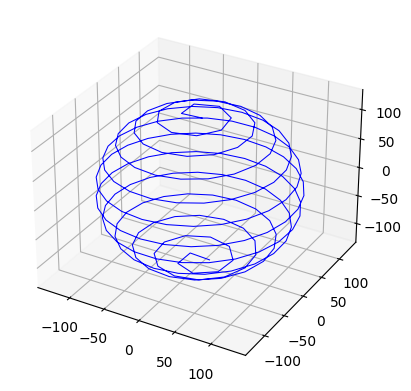

In [ ]:
k_traj_adc, k_traj, t_excitation, t_refocusing, t_adc = seq.calculate_kspace()

nAdc = adc.num_samples
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(k_traj_adc[0, nAdc-1::nAdc], k_traj_adc[1, nAdc-1::nAdc], k_traj_adc[2, nAdc-1::nAdc], c='blue')

Calculate the distance between the last sample of the first readout and the last sample of the second readout, to check the Nyquist condition. This only works for linear steps in acquisition angle.

In [ ]:
from google.colab import files
uploaded = files.upload();

assert len(uploaded.keys()) == 2, 'Upload exactly two files!'

filename = [x for x in uploaded.keys() if x.endswith('.dat')]
if filename == []:
    raise ValueError('No .dat file uploaded')
filename = filename[0]

seq_filename = [x for x in uploaded.keys() if x.endswith('.seq')]
if seq_filename == []:
    raise ValueError('No .seq file uploaded')
seq_filename = seq_filename[0]



# Exercises

## 1. Implement variable TE

Currently, the sequence minimizes TE. Hoewever, when measuring T2* multiple echoes are necessary to fit an exponential decay to the data. Adapt the sequence such that TE can be specified next to TR and implement the pause between RF-pulse and ADC.

## 2. Implement DA-3DPR

To improve SNR, you can try and increase the sampling density in the periphery of k-space. Follow the implementation of a density adapted 3D radial trajectory from [Nagel A., et al.](https://doi.org/10.1002/mrm.22157)

**Hints**

Define the readout gradient in two steps. Use `make_extended_trapezoid` to construct the ramp-up and plateau phase of the gradient, followed by an arbitrary gradient waveform with `make_arbitrary_grad`.

Even though equation 7 in the paper contains gamma, you should be able to implement the trajectory entirely without the need for conversion between Hz/m and mT/m.

## 3. Calibration of reference voltage

Write a sequence you can use when to calibrate the reference voltage.

This sequence is a simple 'fid'-sequence with a rectangluar RF-excitation pulse with a duration of 1ms and the flipangle set to 90°. Start the ADC after TE and acquire data for 1ms. After the ADC, apply a strong spoiling gradient by ramping to the maximum gradient amplitude, stay there for 5ms and then ramping down to 0. Acquire multiple averages to improve SNR.

Repeat your measurements while manually increasing the reference voltage of the MRI machine. When the recieved signal is maximized, you have found the reference voltage of your coil.
